# Iterative Qubit Coupled Cluster using only Clifford circuits

This notebook shows how to implement iQCC using only Clifford circuits with Tangelo, and accompanies a note released at [arXiv:2211.10501](https://arxiv.org/abs/2211.10501). We provide here the abstract of the article in this notebook for convenience and highlight the main steps of our implementation. Please refer to the article for full details.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/goodchemistryco/Tangelo/blob/develop/examples/iqcc_using_clifford.ipynb)

### Abstract
We draw attention to a variant of the iterative qubit coupled cluster (iQCC) method that only
uses Clifford circuits. The iQCC method relies on a small parameterized wave function ansatz, which
takes form as a product of exponentiated Pauli word operators, to approximate the ground state
electronic energy of a mean field reference state through iterative qubit Hamiltonian transformations.
In this variant of the iQCC method, the wave function ansatz at each iteration is restricted to a single
exponentiated Pauli word operator and parameter. The Rotosolve algorithm utilizes Hamiltonian
expectation values computed with Clifford circuits to optimize the single-parameter Pauli word
ansatz. Although the exponential growth of Hamiltonian terms is preserved with this variation
of iQCC, we suggest several methods to mitigate this effect. This method is useful for near-term
variational quantum algorithm applications as it generates good initial parameters by using Clifford
circuits which can be efficiently simulated on a classical computers according to the Gottesman–Knill
theorem. It may also be useful beyond the NISQ era to create short-depth Clifford pre-optimized
circuits that improve the success probability for fault-tolerant algorithms such as phase estimation.

In [1]:
# Installation of tangelo if not already installed.
try:
    import tangelo
except ModuleNotFoundError:
    !pip install git+https://github.com/goodchemistryco/Tangelo.git@develop --quiet

### Define Clifford simulator

We define a Clifford simulator using cirq. This is a child class of `CirqSimulator` where we overwrite `simulate_circuit` and use `cirq.CliffordSimulator`.

In [2]:
import numpy as np

from tangelo.linq import Circuit
from tangelo.linq.target.target_cirq import CirqSimulator
from tangelo.linq.target.backend import Backend
from tangelo.linq.translator import translate_circuit as translate

class CirqCliffordSimulator(CirqSimulator):

    def simulate_circuit(self, source_circuit: Circuit, return_statevector=False, initial_statevector=None):
        """Perform state preparation corresponding to the input circuit using cirq.CliffordSimulator

        Args:
            source_circuit: a circuit in the Tangelo format to be translated
            return_statevector (bool): option to return the statevector.
            initial_statevector(list/array) : Not currently supported

        Returns:
            dict: A dictionary mapping multi-qubit states to their corresponding frequency.
            numpy.array: The statevector, if available for the target backend
                and requested by the user (if not, set to None).
        """

        cirq_circuit = translate(source_circuit, "cirq")
        self.circuit = cirq_circuit

        cirq_simulator = self.cirq.CliffordSimulator()

        self.result = cirq_simulator.simulate(cirq_circuit)
        self._current_state = self.result.final_state.to_numpy()
        frequencies = self._statevector_to_frequencies(self._current_state)

        # If requested, set initial state
        if initial_statevector is not None:
            raise ValueError(f"Initial statevector is not currently supported in {self.__class__}")

        return (frequencies, self._current_state) if return_statevector else (frequencies, None)


### Class that implements iQCC using only Clifford circuits
The `iQCConlyClifford` class is defined as a child class of `ADAPTSolver` and replaces the `simulate` and `rank_pool` functions. A non-clifford backend is used only to check that the full circuit obtains the same energy using the original qubit hamiltonian.

In [3]:
from typing import Type
from copy import deepcopy

from tangelo.algorithms import ADAPTSolver
from tangelo.linq import Circuit
from tangelo.toolboxes.operators import QubitOperator
from tangelo.toolboxes.ansatz_generator.ansatz_utils import get_exponentiated_qubit_operator_circuit
from tangelo.toolboxes.molecular_computation.molecule import SecondQuantizedMolecule
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
from tangelo.toolboxes.ansatz_generator._qubit_cc import get_dis_groups, get_gens_from_idxs
from tangelo.toolboxes.ansatz_generator._qubit_mf import init_qmf_from_hf
from tangelo.toolboxes.ansatz_generator._qubit_cc import qcc_op_dress


class iQCConlyClifford(ADAPTSolver):
    """iQCC using only Clifford Class. This is an iterative algorithm that uses Clifford circuits
    along with Rotosolve to rank single Pauli word operators and obtain its optimal energy and rotation.

    Attributes:
        molecule (SecondQuantizedMolecule): The molecular system.
        tol (float): Maximum gradient allowed for a particular operator  before
            convergence.
        max_cycles (int): Maximum number of iterations for ADAPT.
        pool (func): Function that returns a list of FermionOperator. Each
            element represents excitation/operator that has an effect of the
            total energy.
        pool_args (dict) : The arguments for the pool function. Will be unpacked in
            function call as pool(**pool_args)
        qubit_mapping (str): One of the supported qubit mapping identifiers.
        qubit_hamiltonian (QubitOperator-like): Self-explanatory.
        up_then_down (bool): Spin orbitals ordering.
        n_spinorbitals (int): Self-explanatory.
        n_electrons (int): Self-explanatory.
        optimizer (func): Optimization function for VQE minimization.
        backend_options (dict): Backend options for the underlying VQE object.
        verbose (bool): Flag for verbosity of VQE.
        deflation_circuits (list[Circuit]): Deflation circuits to add an
            orthogonalization penalty with.
        deflation_coeff (float): The coefficient of the deflation.
        ref_state (array or Circuit): The reference configuration to use. Replaces HF state
        clifford_simulator(Type[Backend]): The clifford simulator used for the operator selection
            and minimization.
     """

    def __init__(self, opt_dict: dict, clifford_simulator: Type[Backend]):
        super().__init__(opt_dict=opt_dict)
        self.clifford_simulator = clifford_simulator
        self.qu_op_length = []

    def rank_pool(self, circuit: Circuit, backend: Type[Backend]):
        """Rank pool of operators with a specific circuit.

        Args:
            reference_circuit (tangelo.linq.Circuit): Reference circuit that only uses Clifford gates
            backend (tangelo.linq.backend): Clifford backend to compute expectation values as child class of Backend

        Returns:
            int: Index of the operators with the highest gradient. If it is not
                bigger than tolerance, returns -1.
        """

        if len(self.vqe_solver.ansatz.operators) > 0:
            dressed_qu_op = qcc_op_dress(deepcopy(self.qubit_hamiltonian), self.vqe_solver.ansatz.operators[::-1],
                                                  self.vqe_solver.optimal_var_params[::-1])
            self.energies[-1] = backend.get_expectation_value(dressed_qu_op, self.vqe_solver.ansatz.prepare_reference_state())
            print("Dressed Hamiltonian, same initial state energy", self.energies[-1])
        else:
            dressed_qu_op = self.qubit_hamiltonian

        self.qu_op_length.append(len(dressed_qu_op.terms))
        self.pool_operators = self.pool(self.molecule, self.qubit_mapping, self.up_then_down, dressed_qu_op)

        len_pool = len(self.pool_operators)
        thetas = np.zeros(len_pool)
        eners = np.zeros(len_pool)
        for i, pool_op in enumerate(self.pool_operators):
            # get_exponentiated_qubit_operator_circuit multiplies time by 2
            cpl = get_exponentiated_qubit_operator_circuit(pool_op, time=np.pi/4)
            cmi = get_exponentiated_qubit_operator_circuit(pool_op, time=-np.pi/4)

            epl = backend.get_expectation_value(dressed_qu_op, circuit+cpl)
            emi = backend.get_expectation_value(dressed_qu_op, circuit+cmi)

            ener = self.energies[-1]
            theta_min = -0.5 * np.pi - np.arctan2(2. * ener - epl - emi, epl - emi)
            a = 0.5*np.sqrt((2*ener-epl-emi)**2+(epl-emi)**2)
            b = np.arctan2(2. * ener - epl - emi, epl - emi)
            c = 1/2*(epl+emi)
            eners[i] = a*np.sin(theta_min+b)+c
            thetas[i] = theta_min

        index = np.argmin(eners)
        self.new_param = thetas[index]
        if self.verbose:
            print(f'Chosen parameter is {self.new_param} with energy {eners[index]}')

        return index if self.energies[-1]-eners[index] > self.tol else -1

    def simulate(self):
        """Performs the iQCC cycles. No VQE minimization is performed but there is a check of the full circuit
        with the initial Hamiltonian
        """

        params = self.vqe_solver.ansatz.var_params
        self.new_param = 0.

        self.energies.append(self.vqe_solver.energy_estimation([]))

        # Construction of the ansatz. self.max_cycles terms are added, unless
        # all operator gradients are less than self.tol.
        while self.iteration < self.max_cycles:
            self.iteration += 1
            if self.verbose:
                print(f"\n Iteration {self.iteration} of iQCC using only Clifford circuits.")

            ref_circuit = (self.vqe_solver.ansatz.prepare_reference_state() if self.ref_state is None else
                            self.vqe_solver.reference_circuit + self.vqe_solver.ansatz.prepare_reference_state())

            pool_select = self.rank_pool(ref_circuit,
                                         backend=self.clifford_simulator)

            # If pool selection returns an operator that changes the energy by
            # more than self.tol. Else, the loop is complete and the energy is
            # considered as converged.
            if pool_select > -1:

                # Adding a new operator to beginning of operator list
                # Previous parameters are kept as they were.
                self.vqe_solver.ansatz.operators = [self.pool_operators[pool_select]] + self.vqe_solver.ansatz.operators
                params = [self.new_param] if self.vqe_solver.optimal_var_params is None else [self.new_param] + list(self.vqe_solver.optimal_var_params)
                

                self.vqe_solver.ansatz._n_terms_operators = [1] + self.vqe_solver.ansatz._n_terms_operators
                self.vqe_solver.ansatz._var_params_prefactor = [1] + self.vqe_solver.ansatz._var_params_prefactor
                self.vqe_solver.initial_var_params = params
                self.vqe_solver.ansatz.build_circuit()

                # Non-clifford simulator used to verify that the energy is the same as determined using the Clifford simulator.
                self.vqe_solver.optimal_energy = self.vqe_solver.energy_estimation(params)
                if self.verbose:
                    print(f"Full circuit with original Hamiltonian energy = {self.vqe_solver.optimal_energy}")
                self.vqe_solver.optimal_var_params = params

                opt_energy = self.vqe_solver.optimal_energy
                params = list(self.vqe_solver.optimal_var_params)
                self.energies.append(opt_energy)
            else:
                self.converged = True
                break

        return self.energies[-1]

def full_qcc_pool(mol: SecondQuantizedMolecule, mapping: str, up_then_down: bool, qubit_hamiltonian: QubitOperator):
    """Generate all possible generators in the DIS for qubit_hamiltonian
    
    Args:
        mol (SecondQuantizedMolecule): The molecule to determine the DIS pool for.
        mapping (str): One of the support qubit mappings
        up_then_down (bool): Spin orbitals ordering. True is all alpha then beta orbitals. False is alternating.
        qubit_hamiltonian (QubitOperator): The current dressed qubit hamiltonian.

    Returns:
        list: DIS pool operators
    """
    qmf_var_params = init_qmf_from_hf(mol.n_active_sos, mol.n_active_electrons, 
                                      mapping, up_then_down, mol.spin)

    dis, dis_groups = [], get_dis_groups(qubit_hamiltonian, qmf_var_params, 3.e-5)
    for dis_group in dis_groups:
        dis_group_idxs = [int(idxs) for idxs in dis_group[0].split(" ")]
        dis_group_gens = get_gens_from_idxs(dis_group_idxs)
        dis.append(dis_group_gens)
    dis_flat = [item for sublist in dis for item in sublist]
    return dis_flat


### Running the algorithm for H<sub>3</sub>

In [4]:
from tangelo.toolboxes.molecular_computation.molecule import SecondQuantizedMolecule
from tangelo.algorithms.classical import FCISolver

# Define molecular system
xyz_H3 = [
    ("H", (0., 0., 0.)),
    ("H", (0., 0., 0.7414)),
    ("H", (0., 0., 2*0.7414))
]
mol = SecondQuantizedMolecule(xyz_H3, q=0, spin=1, basis="sto-3g")
max_cycles = 4

# Calculate reference FCI energy
cc = FCISolver(mol)
exact = cc.simulate()

mapping = "JKMN"

qu_op = fermion_to_qubit_mapping(mol.fermionic_hamiltonian, mapping, mol.n_active_sos, mol.n_active_electrons, up_then_down=False, spin=mol.active_spin)
pool_args = {"mol": mol, "mapping": mapping, "up_then_down": False, "qubit_hamiltonian": qu_op}

backend_options = {}  # {"target": QulacsSimulator}
opt_dict = {"molecule": mol, "tol": 1.e-9, "max_cycles": max_cycles, "verbose": True,
            "qubit_mapping": mapping, "n_spinorbitals": mol.n_active_sos, "n_electrons": mol.n_active_electrons, 
            "pool": full_qcc_pool, "pool_args": pool_args, "up_then_down": False, "backend_options": backend_options}

iQCC_C_solver = iQCConlyClifford(opt_dict, CirqCliffordSimulator())
iQCC_C_solver.build()
iQCC_C_solver.simulate()
print("\nThe pool operators used are")
print(iQCC_C_solver.ansatz.operators)
print("with corresponding parameters")
print(iQCC_C_solver.vqe_solver.optimal_var_params)
print(f"\n The final energy is {iQCC_C_solver.energies[-1]} with error {iQCC_C_solver.energies[-1]-exact}")
print("\n The number of H terms at each iteration is")
print(iQCC_C_solver.qu_op_length)
#adapt_circ = adapt_solver.vqe_solver.optimal_circuit



 Iteration 1 of iQCC using only Clifford circuits.
Chosen parameter is 0.19497620390733506 with energy -1.5146298806979668
Full circuit with original Hamiltonian energy = -1.5146298806979654

 Iteration 2 of iQCC using only Clifford circuits.
Dressed Hamiltonian, same initial state energy -1.5146298806979663
Chosen parameter is -0.10349849269458078 with energy -1.5218965900518353
Full circuit with original Hamiltonian energy = -1.5218965900518329

 Iteration 3 of iQCC using only Clifford circuits.
Dressed Hamiltonian, same initial state energy -1.521896590051836
Chosen parameter is 0.08657354901273173 with energy -1.5244271035716803
Full circuit with original Hamiltonian energy = -1.5244271035716768

 Iteration 4 of iQCC using only Clifford circuits.
Dressed Hamiltonian, same initial state energy -1.5244271035716799
Chosen parameter is -0.08225117291478923 with energy -1.5267582996827964
Full circuit with original Hamiltonian energy = -1.526758299682792

The pool operators used are
[1

### Plots of energy convergence and growth of Hamiltonian terms

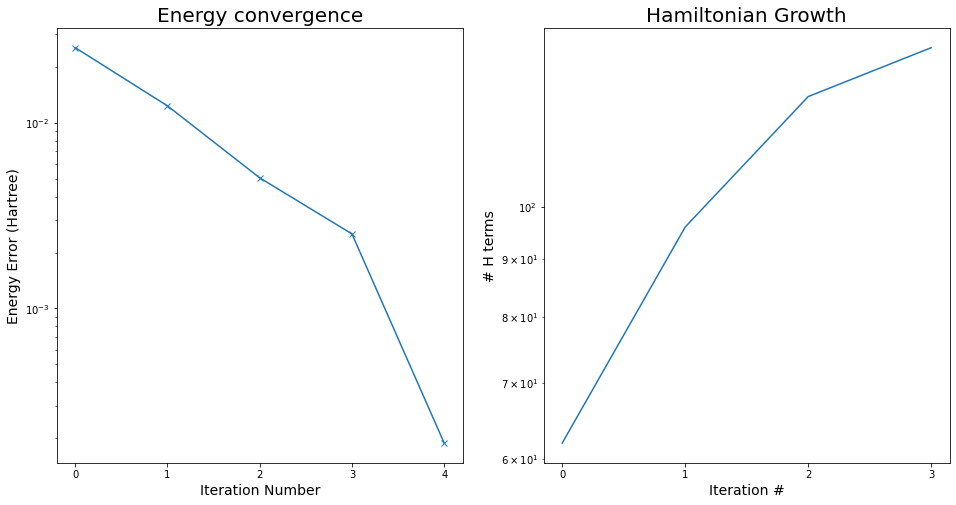

In [5]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)

ax1.set_xticks(list(range(len(iQCC_C_solver.energies))))
ax1.set_title("Energy convergence", fontdict={"size": 20})
ax1.set_xlabel("Iteration Number", fontdict={"size": 14})
ax1.set_ylabel("Energy Error (Hartree)", fontdict={"size": 14})
ax1.semilogy(range(len(iQCC_C_solver.energies)), np.abs(iQCC_C_solver.energies-exact), "-x" )

ax2.set_title("Hamiltonian Growth", fontdict={"size": 20})
ax2.set_ylabel("# H terms", fontdict={"size": 14})
ax2.set_xticks(list(range(len(iQCC_C_solver.qu_op_length))))
ax2.set_xlabel("Iteration #", fontdict={"size": 14})
ax2.semilogy(list(range(len(iQCC_C_solver.qu_op_length))), iQCC_C_solver.qu_op_length)

### Optimizing interior generators

Below is the method highlighted in the manuscript to optimize interior generators

In [6]:
from tangelo.linq import get_backend, Gate, Circuit
dressed_qu_op = qcc_op_dress(deepcopy(iQCC_C_solver.qubit_hamiltonian),
                             iQCC_C_solver.vqe_solver.ansatz.operators[::-1],
                             iQCC_C_solver.vqe_solver.optimal_var_params[::-1])
ref_circ = iQCC_C_solver.vqe_solver.ansatz.prepare_reference_state()

In [7]:
def optimize_interior_generator(op_index, ref_circ):
    dressed_qu_op = qcc_op_dress(deepcopy(iQCC_C_solver.qubit_hamiltonian),
                                 list(reversed(iQCC_C_solver.vqe_solver.ansatz.operators[op_index+1:4])),
                                 list(reversed(iQCC_C_solver.vqe_solver.optimal_var_params[op_index+1:4])))
    dressed_ref_qu_op = QubitOperator((), 1)
    for i in range(op_index-1, -1, -1):
        p = iQCC_C_solver.vqe_solver.optimal_var_params[i]
        q = iQCC_C_solver.vqe_solver.ansatz.operators[i]
        dressed_ref_qu_op *= (np.cos(p/2)*QubitOperator((), 1) - 1j*np.sin(p/2)*q)

    # CirqCliffordSimulator is very slow but does work
    # sim = CirqCliffordSimulator()
    # Use default simulator instead, ideally qulacs is installed
    sim = get_backend()
    

    expect0 = 0
    expectpl = 0
    expectmi = 0
    circpl = get_exponentiated_qubit_operator_circuit(iQCC_C_solver.ansatz.operators[op_index], time=np.pi/4)
    circmi = get_exponentiated_qubit_operator_circuit(iQCC_C_solver.ansatz.operators[op_index], time=-np.pi/4)
    circ0 = get_exponentiated_qubit_operator_circuit(iQCC_C_solver.ansatz.operators[op_index], time=0)

    zero_one_qu_op = QubitOperator("X6") + QubitOperator("Y6", 1j)

    for term1, coeff1 in dressed_ref_qu_op.terms.items():
        ref_circ1 = Circuit([Gate("C"+op, q, 6) for q, op in term1], n_qubits=7)

        for term2, coeff2 in dressed_ref_qu_op.terms.items():
            ref_circ2 = Circuit([Gate("C"+op, q, 6) for q, op in term2], n_qubits=7)

            prep_12_circuit = ref_circ + Circuit([Gate("H", 6)]) + ref_circ1 + Circuit([Gate("X", 6)]) + ref_circ2

            for hterm, hcoeff in dressed_qu_op.terms.items():
                qu_circ = Circuit([Gate("C"+op, q, 6) for q, op in hterm], n_qubits=7)
                
                plus_circ = prep_12_circuit + circpl + qu_circ + Circuit([Gate("X", 6)])
                expectpl += sim.get_expectation_value(zero_one_qu_op, plus_circ) * coeff1 * np.conj(coeff2) * hcoeff
                
                minus_circ = prep_12_circuit + circmi + qu_circ + Circuit([Gate("X", 6)])
                expectmi += sim.get_expectation_value(zero_one_qu_op, minus_circ) * coeff1 * np.conj(coeff2) * hcoeff

                zero_circ = prep_12_circuit + circ0 + qu_circ + Circuit([Gate("X", 6)])
                expect0 += sim.get_expectation_value(zero_one_qu_op, zero_circ) * coeff1 * np.conj(coeff2) * hcoeff
    ener= expect0.real
    epl = expectpl.real
    emi = expectmi.real
    theta_min = -0.5 * np.pi - np.arctan2(2. * ener - epl - emi, epl - emi)
    a = 0.5*np.sqrt((2*ener-epl-emi)**2+(epl-emi)**2)
    b = np.arctan2(2. * ener - epl - emi, epl - emi)
    c = 1/2*(epl+emi)
    new_energy = a*np.sin(theta_min+b)+c

    return theta_min, new_energy


Perform one rotosolve sweep

In [8]:
starting_energy = iQCC_C_solver.vqe_solver.energy_estimation(iQCC_C_solver.vqe_solver.optimal_var_params)
print(f"iQCC using only Clifford circuits results in energy {starting_energy} with error {starting_energy-exact}")

# Start at max_cycles-1 as operator 0 was the last optimized.
for op_index in range(max_cycles-1, -1, -1):
    theta_min, new_energy = optimize_interior_generator(op_index, ref_circ)
    print(f"\n Optimizing operator {op_index} results in new energy of {new_energy}")
    iQCC_C_solver.vqe_solver.optimal_var_params[op_index] = theta_min
    calculated_new_energy = iQCC_C_solver.vqe_solver.energy_estimation(iQCC_C_solver.vqe_solver.optimal_var_params)
    print(f"The calculated new energy is {calculated_new_energy} with error {calculated_new_energy-exact}")

iQCC using only Clifford circuits results in energy -1.526758299682792 with error 0.0001887054536875432

 Optimizing operator 3 results in new energy of -1.5268018129766077
The calculated new energy is -1.5268018129766032 with error 0.00014519215987629508

 Optimizing operator 2 results in new energy of -1.5268018780136394
The calculated new energy is -1.526801878013637 with error 0.0001451271228425366

 Optimizing operator 1 results in new energy of -1.5268303820972458
The calculated new energy is -1.5268303820972426 with error 0.0001166230392368739

 Optimizing operator 0 results in new energy of -1.5268319664163135
The calculated new energy is -1.5268319664163106 with error 0.00011503872016893624


## Closing words

This notebook shows that a variant of iQCC can be implemented while only using Clifford circuits as described in our [manuscript](https://arxiv.org/abs/2211.10501). This method can be used to initialize the QCC ansatz for VQE or to create short depth circuits that improve the success probability of fault-tolerant algorithms such as phase estimation. 